In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/dalia_individual_windows_20.p','rb'))

In [3]:
def get_train_test_val_data(X_hr,y_participant,y_time,y_activity):
    all_data = pd.DataFrame({'x':np.arange(X_hr.shape[0]),'y':y_participant,'time':y_time,'activity':y_activity})
    train_percentage = .6
    val_percentage = train_percentage+.1
    def split_data(df):
        df = df.sort_values('time').reset_index(drop=True)
        n = df.shape[0]
        train_index = df['x'].values[:int(n*train_percentage)]
        val_index = df['x'].values[int(n*train_percentage):int(n*val_percentage)]
        test_index = df['x'].values[int(n*val_percentage):]
        return pd.DataFrame({'train':[list(train_index)],'val':[list(val_index)],'test':[list(test_index)]})

    index_df = all_data.groupby(['y','activity'],as_index=False).apply(split_data)

    from functools import reduce
    train_index = np.array(reduce(lambda a,b:a+b,index_df['train'].values))
    val_index = np.array(reduce(lambda a,b:a+b,index_df['val'].values))
    test_index = np.array(reduce(lambda a,b:a+b,index_df['test'].values))


    train_x,train_y = X_hr[train_index],y_participant[train_index]
    val_x,val_y = X_hr[val_index],y_participant[val_index]
    test_x,test_y = X_hr[test_index],y_participant[test_index]
    return train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index 

In [4]:
window_size = 20
n_timesteps = 20*32
n_channels = 1
train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index  = get_train_test_val_data(X[:,:,:],
                                                                                                      y_participant,
                                                                                                      y_time,
                                                                                                      y_activity)
train_activity = y_activity[train_index]
test_activity = y_activity[test_index]

In [5]:
train_x.shape,test_x.shape,val_x.shape

((15447, 640, 4), (7816, 640, 4), (2576, 640, 4))

In [6]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib inline
from keras.layers import Conv1D,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input,GRU
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats.mstats import winsorize

4 Physical GPUs, 1 Logical GPU


In [7]:
def get_model(input_shape=(256,4),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=350,n_output = 15):
    
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,40,input_shape=input_shape,activation='selu',kernel_initializer='normal',padding='same'))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Conv1D(50,40,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
#     model.add(BatchNormalization())
#     model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
#     model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    
    model.add(Conv1D(200,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(BatchNormalization())
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Dropout(.2))
    model.add(Flatten())
#     model.add(Dense(n_classes,activation='relu'))
#     model.add(Dense(n_output*2,activation='relu'))
    model.add(Dense(n_output,activation=None))
    model.summary()
    input_ = Input(shape=input_shape)
    reshaped_input = Reshape(input_shape)(input_)
    embedding = model(reshaped_input)
    embedding = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='feature')(embedding)
    
#     class_embedding = Dense(n_output,activation='sigmoid')(final_embedding)
    y_output = Dense(n_output,activation='softmax',name='output')(embedding) 
    model1 = Model(input_,y_output)
#     model1.compile(loss={'output':tf.keras.losses.SparseCategoricalCrossentropy(),
#                         'feature':tfa.losses.TripletSemiHardLoss()},optimizer=opt,
#                    loss_weights={'output':1,'feature':0})
    model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam')
    return model1

model1 = get_model(input_shape=(n_timesteps,1))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 640, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 640, 100)          4100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 640, 50)           200050    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 320, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 320, 100)          100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 160, 100)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 100)          4

In [8]:
n_classes = 300
n_output = len(np.unique(y_participant))
model = get_model(input_shape=(n_timesteps,1),n_classes=n_classes,n_output=n_output) 
model.summary()
from keras.models import load_model
filepath = '../model_files/base_cnn_60_seconds_raw_ppg_only_classification.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40)
callbacks_list = [es,checkpoint]
history = model.fit(train_x[:,:,:1],train_y,validation_data=(val_x[:,:,:1],val_y), epochs=400, 
                    batch_size=200,callbacks=callbacks_list,shuffle=True,verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 640, 1)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 640, 100)          4100      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 640, 50)           200050    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 320, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 320, 100)          100100    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 160, 100)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 160, 100)         

In [9]:
model.load_weights(filepath)
y_pred = model.predict(test_x[:,:,:1]).argmax(axis=1)

In [10]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(test_y,y_pred),accuracy_score(test_y,y_pred))

              precision    recall  f1-score   support

           0       0.31      0.22      0.25       547
           1       0.22      0.16      0.18       552
           2       0.23      0.22      0.22       480
           3       0.34      0.38      0.36       527
           4       0.55      0.51      0.53       564
           5       0.41      0.45      0.43       477
           6       0.34      0.28      0.31       316
           7       0.35      0.25      0.30       550
           8       0.58      0.40      0.47       642
           9       0.44      0.65      0.53       561
          10       0.28      0.38      0.32       518
          11       0.26      0.25      0.26       489
          12       0.40      0.49      0.44       496
          13       0.28      0.28      0.28       541
          14       0.27      0.34      0.30       556

    accuracy                           0.35      7816
   macro avg       0.35      0.35      0.34      7816
weighted avg       0.36   

In [19]:
test_hr = y_hr[test_index]

In [20]:
test_df = pd.DataFrame({'hr':test_hr,
                        'original':test_y,
                        'prediction':y_pred,
                        'activity':test_activity,
                        'data':[np.array(a) for a in test_x]})

In [21]:
from scipy.stats import mode
n = 100
len_col = np.arange(2,60,2)
# for l in len_col:
def get_ensemble_score(df):
    results = []
    original = df['original'].values[0]
    for l in len_col:
        count = 0
        for _ in range(n): 
            ensemble_prediction = mode(df.sample(l)['prediction'])[0][0]
            if original==ensemble_prediction:
                count+=1
        results.append(count/n)
    return pd.DataFrame({'ensemble_size':np.array(len_col),'accuracy':results,'participant':[original]*len(len_col)})

emsemble_df = test_df.groupby('original').apply(get_ensemble_score).reset_index(drop=True)

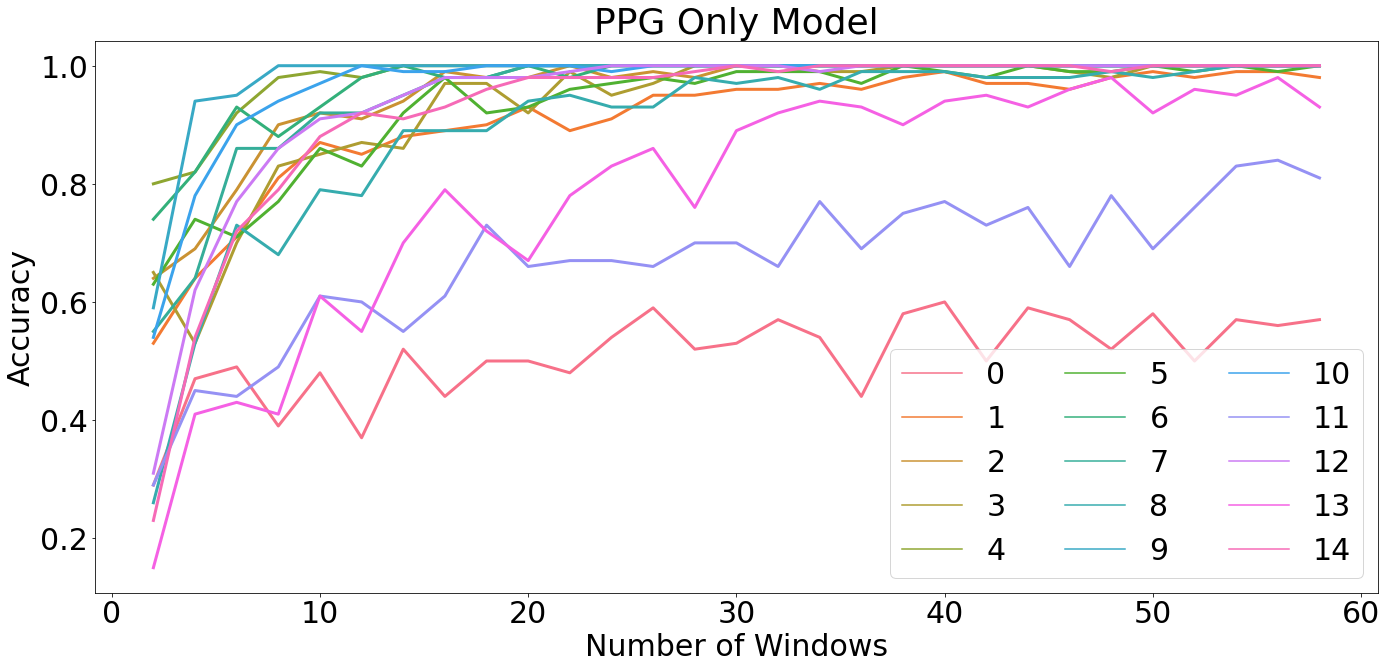

In [37]:
import seaborn as sns
emsemble_df['participant'] = emsemble_df['participant'].astype(str)
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.lineplot(x='ensemble_size',y='accuracy',hue='participant',data=emsemble_df,linewidth=3)
plt.ylabel('Accuracy')
plt.xlabel('Number of Windows')
plt.legend(ncol=3)
plt.title('PPG Only Model')
plt.savefig('ppg_only.png')
plt.tight_layout()
plt.show()

In [38]:
activity_dict = {0:'No Label',
                1:'Sitting',
                2:'Stairs',
                3:'Soccer',
                4:'Cycling',
                5:'Driving',
                6:'Lunch',
                7:'Walking',
                8:'Working'}
# activity_dict_reverse = {activity_dict[k]:k f}

In [39]:
import numpy as np
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
hrs = np.arange(50,150,10)
test_df['discrete_hr'] = test_df['hr'].apply(lambda a:find_nearest(hrs,a))

In [40]:
test_df.head()

,hr,original,prediction,activity,data,discrete_hr
0,117.352056,0,0,0.0,"[[106.2696661151563, -0.00439453125, 0.0158691...",120
1,119.504908,0,0,0.0,"[[42.435546291562936, -0.0078125, 0.0166015625...",120
2,120.842106,0,0,0.0,"[[-195.14425126022024, -0.006103515625, 0.0180...",120
3,121.207856,0,0,0.0,"[[73.7562435418138, -0.005615234375, 0.0192871...",120
4,121.624558,0,7,0.0,"[[79.08072126511756, -0.003173828125, 0.015380...",120


In [41]:
def get_score(df):
#     print(df['original'].values[0],df['discrete_hr'].values[0],
#           accuracy_score(df['original'],df['prediction']))
    return pd.DataFrame([[df['original'].values[0],df['discrete_hr'].values[0],
                         accuracy_score(df['original'],df['prediction']),
                         df['activity'].values[0]]],columns=['original',
                                                                                    'heart_rate',
                                                                                    'accuracy',
                                                                                   'activity'])
heart_rate_scores = test_df.groupby(['original','discrete_hr','activity'],as_index=False).apply(get_score)
heart_rate_scores = heart_rate_scores.reset_index(drop=True)

In [42]:
import seaborn as sns
import seaborn as sns
heart_rate_scores['activity'] = heart_rate_scores['activity'].apply(lambda a:activity_dict[a])

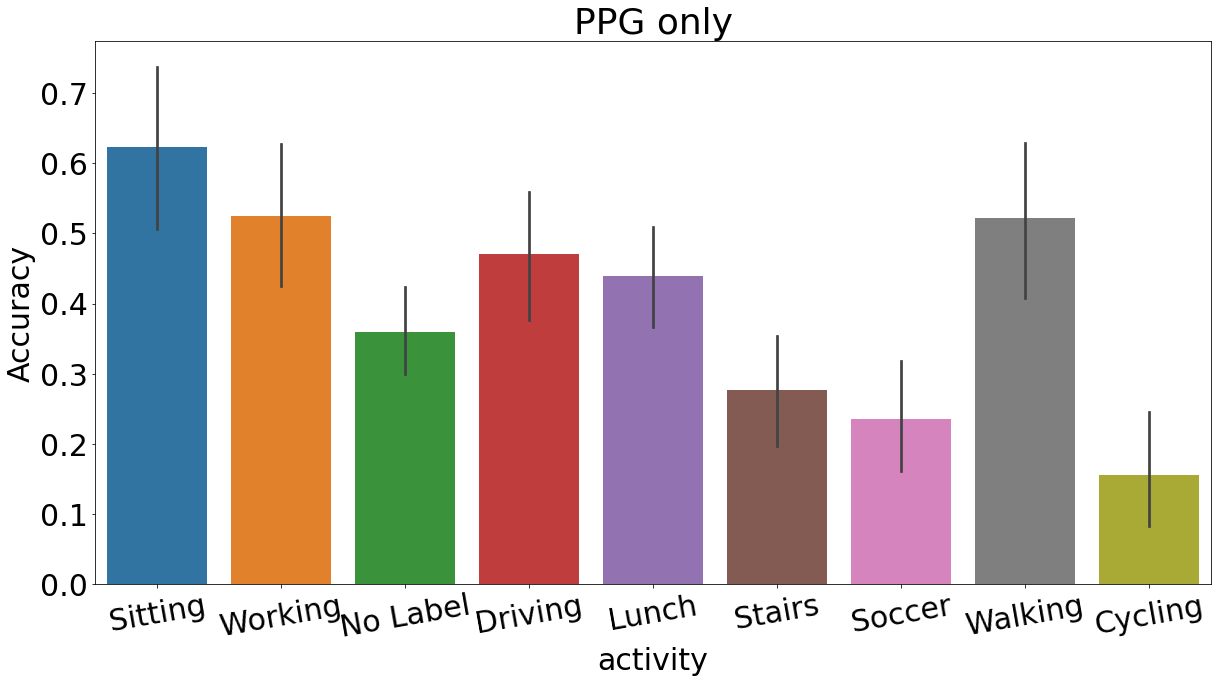

In [43]:
plt.figure(figsize=(20,10))
sns.barplot(x='activity',y='accuracy',data=heart_rate_scores)
# for p in heart_rate_scores['original'].unique():
#     temp = heart_rate_scores[heart_rate_scores.original==p]
#     plt.plot(temp['heart_rate'],temp['accuracy'],'--*')
plt.ylabel('Accuracy')
# plt.xlabel('Number of Windows')
plt.xticks(rotation=10)
plt.title('PPG only')
plt.savefig('ppg_by_activity.png')
plt.show()
plt.show()

In [ ]:
test_df_temp1 = test_df[test_df.original!=test_df.prediction]
test_df_temp2 = test_df[test_df.original==test_df.prediction]

In [ ]:
test_df_temp1.groupby('original').mean()['hr']

In [ ]:
test_df_temp2.groupby('original').mean()['hr']

In [ ]:
from alibi.explainers import IntegratedGradients
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
ig  = IntegratedGradients(model,
                          layer=model.layers[1],
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

explanation = ig.explain(test_x[:,:,:1],
                         baselines=None,
                         target=y_pred)

In [ ]:
explanation.attributions.shape

In [ ]:
test_df['attribution'] = list([np.array(a) for a in explanation.attributions])

In [44]:
test_df['magnitude'] = test_df['data'].apply(lambda a:np.sqrt(np.sum(np.square(a[:,1:]),axis=1)))

In [ ]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
count = 0
for i,row in test_df[::-1].iterrows():
    if activity_dict[row['activity']]!='Sitting':
        continue
    if row['original']!=row['prediction']:
        continue
    count+=1
    if count>100:
        break
    print(row['attribution'].shape)
    fig,ax = plt.subplots(3,1,figsize=(10,8))
#     ax[0].plot(row['data'][:,1:])
    ax[0].plot(row['magnitude'],'r')
    ax[0].set_ylim([-.05,.05])
    ax[1].bar(np.arange(640),MinMaxScaler().fit_transform(np.abs(row['attribution'])).reshape(-1))
    ax[2].plot(row['data'][:,:1].reshape(-1),'g')
    plt.show()

In [139]:
def get_result_df(test_df,f_acl,f_ppg,n1=50,n2=50):
    test_df['acl_std'] = test_df['magnitude'].apply(lambda a:f_acl(a))
    test_df['ppg_std'] = test_df['data'].apply(lambda a:f_ppg(a[:,0]))

    acl_std_array = np.linspace(test_df['acl_std'].min(),test_df['acl_std'].max(),n1)
    test_df['acl_std_discrete'] = test_df['acl_std'].apply(lambda a:find_nearest(acl_std_array,a))
    test_df['acl_std_discrete'] = test_df['acl_std_discrete'].apply(lambda a:int(100*(a/test_df['acl_std_discrete'].max())))

    ppg_std_array = np.linspace(test_df['ppg_std'].min(),test_df['ppg_std'].max(),n2)
    test_df['ppg_std_discrete'] = test_df['ppg_std'].apply(lambda a:find_nearest(ppg_std_array,a))
    test_df['ppg_std_discrete'] = test_df['ppg_std_discrete'].apply(lambda a:int(100*(a/test_df['ppg_std_discrete'].max())))

    def get_result(df):
        acl = df['acl_std_discrete'].values[0]
        ppg = df['ppg_std_discrete'].values[0]
        result = accuracy_score(df['original'],df['prediction'])
        return pd.DataFrame([[acl,ppg,result]],columns=['acl_feature','ppg_feature','accuracy'])
    result_df = test_df.groupby(['acl_std_discrete','original']).apply(get_result)
    return result_df

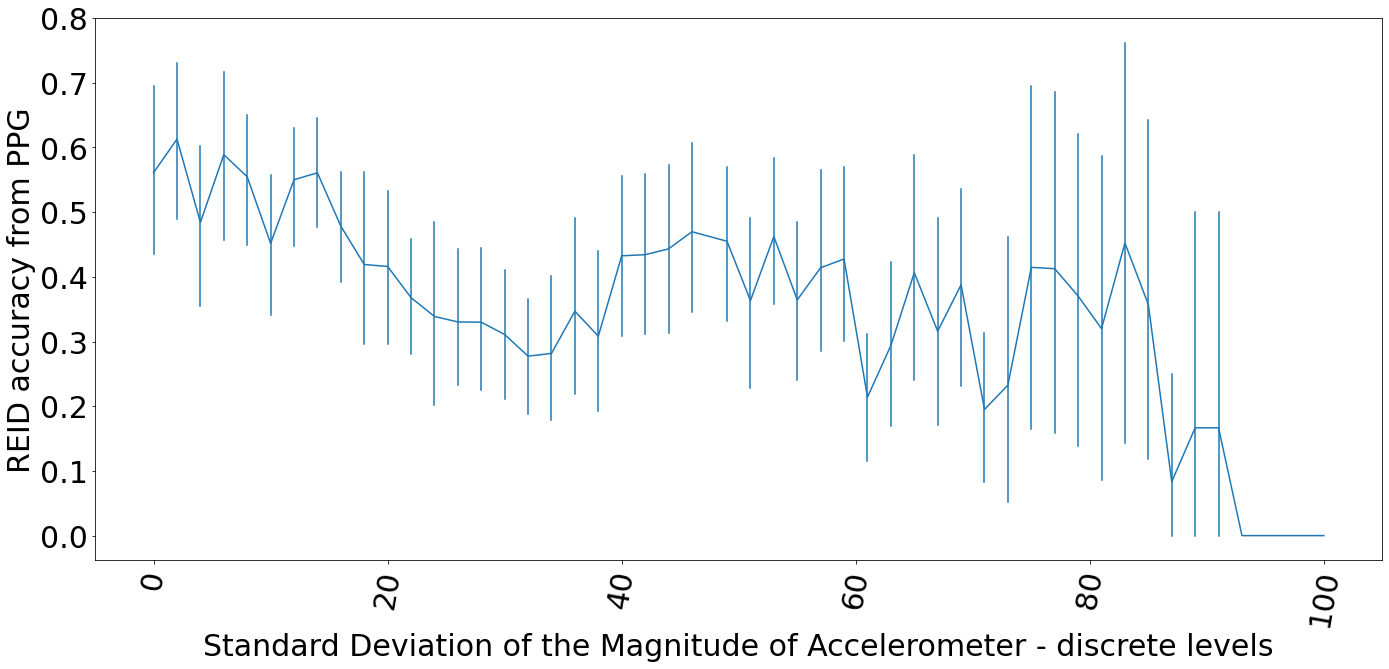

In [142]:
# def 

from scipy.stats import iqr,skew,kurtosis
result_df = get_result_df(test_df.copy(),np.std,skew,50,10)
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,10))
sns.lineplot(x='acl_feature',y='accuracy',data=result_df,err_style="bars")
plt.xlabel('Standard Deviation of the Magnitude of Accelerometer - discrete levels')
plt.ylabel('REID accuracy from PPG')
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig('ppg_reid_vs_acl_std.png')
plt.show()

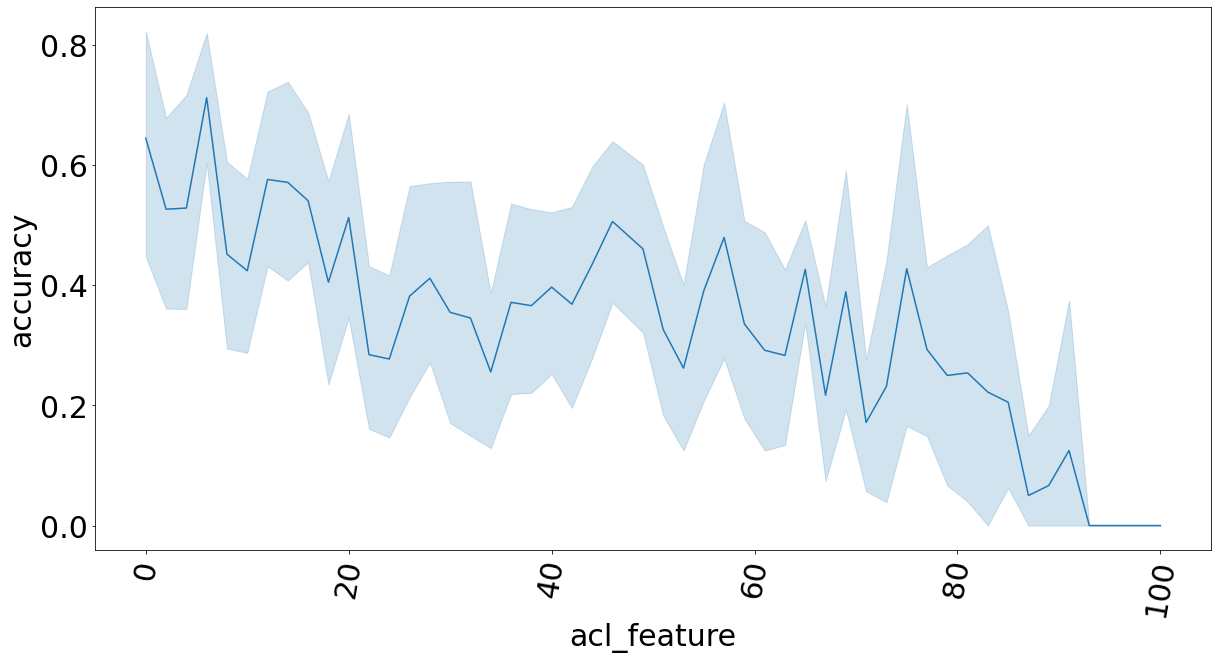

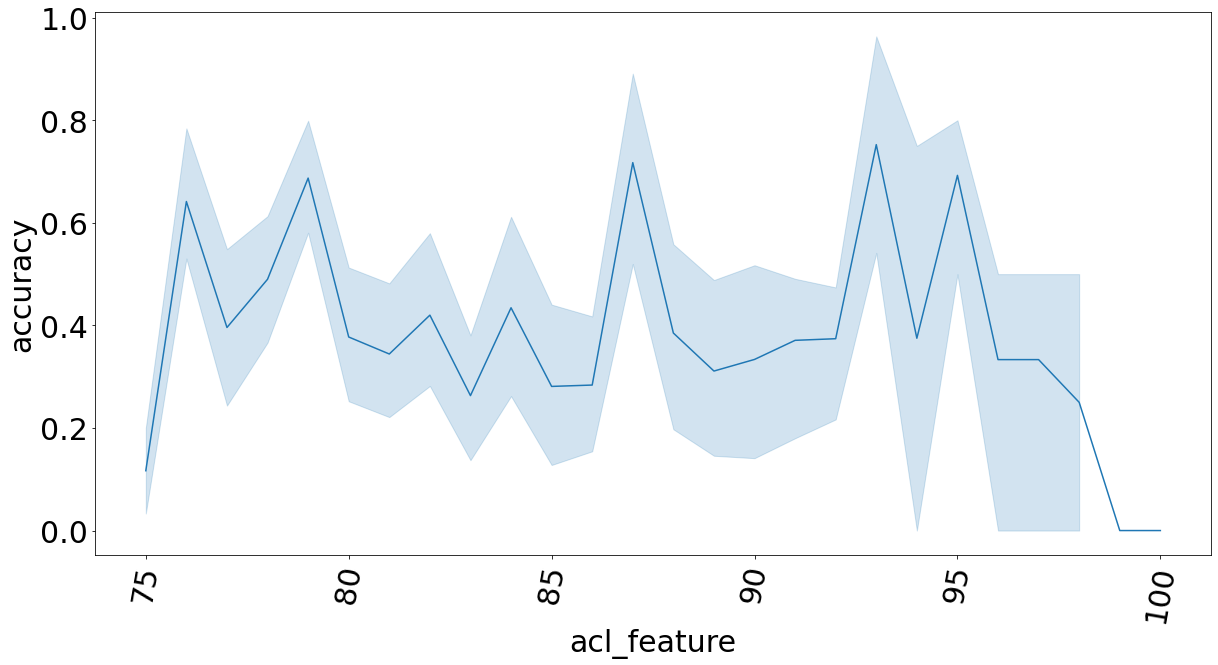

In [125]:
from scipy.stats import iqr,skew,kurtosis
result_df = get_result_df(test_df.copy(),np.mean,skew,50,50)

plt.figure(figsize=(20,10))
sns.lineplot(x='acl_feature',y='accuracy',data=result_df)
plt.xticks(rotation=80)
plt.show()

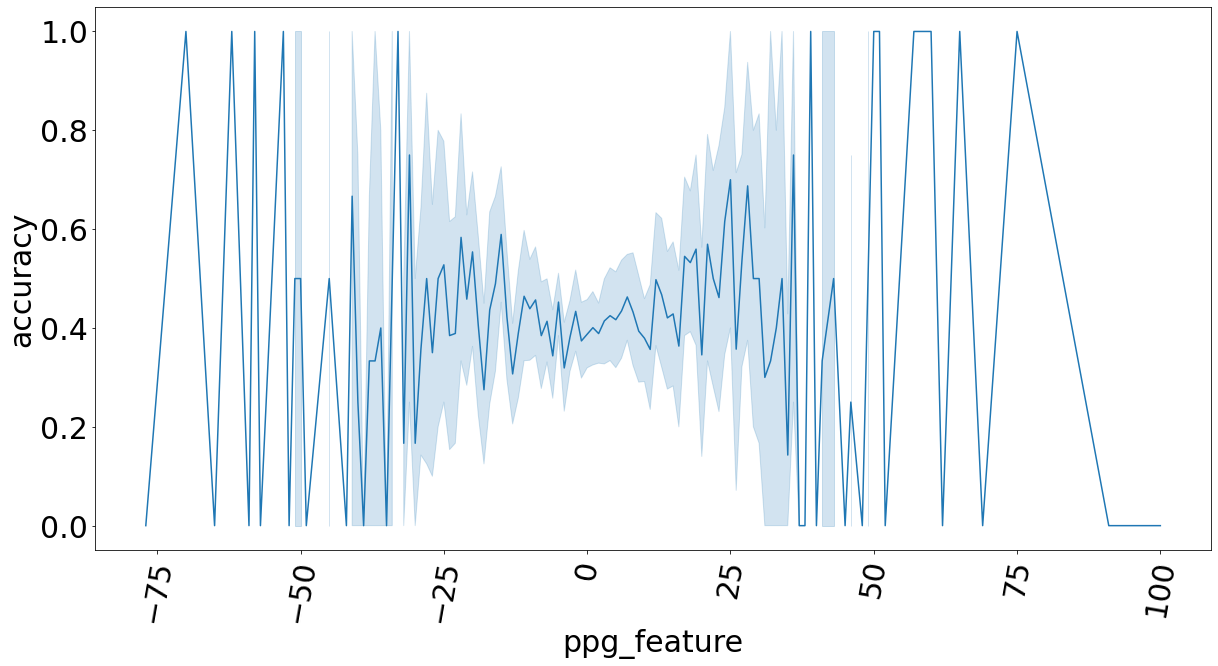

In [126]:
def percentile(a):
    return np.percentile(a,90)
from scipy.stats import iqr,skew,kurtosis
result_df = get_result_df(test_df.copy(),np.std,np.mean,50,200)

plt.figure(figsize=(20,10))
sns.lineplot(x='ppg_feature',y='accuracy',data=result_df)
plt.xticks(rotation=80)
plt.show()